In [1]:
# !pip install larq
# !pip install keras-tuner

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
# print("TensorFlow version:", tf.__version__)
import larq as lq
import keras
import random
from scipy import stats as st
from sklearn.model_selection import train_test_split

# Toy-dataset

In [16]:
num_images_left_under = 50000
num_images_right_above = 50000

dataset_left_under = np.empty((num_images_left_under, 2, 2), dtype=np.uint8)
dataset_right_above = np.empty((num_images_right_above, 2, 2), dtype=np.uint8)

for i in range(num_images_left_under):
    image = np.zeros((2, 2), dtype=np.uint8)
    image[0, 0] = np.random.randint(0, 255) #255 not included
    image[0, 1] = np.random.randint(0, 255)
    image[1, 1] = np.random.randint(0, 255)
    image[1, 0] = 255
    dataset_left_under[i] = image
    
for i in range(num_images_right_above):
    image = np.zeros((2, 2), dtype=np.uint8)
    image[0, 0] = np.random.randint(0, 255)
    image[1, 0] = np.random.randint(0, 255)
    image[1, 1] = np.random.randint(0, 255)
    image[0, 1] = 255
    dataset_right_above[i] = image    

y_left_under = np.full(num_images_left_under, 1)
y_right_above = np.full(num_images_right_above, 0) 


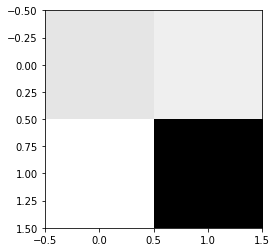

In [17]:
fig = plt.figure
plt.imshow(dataset_left_under[10], cmap='gray')
plt.show()

In [18]:
x_dataset = np.concatenate((dataset_left_under, dataset_right_above))
y_dataset = np.concatenate((y_left_under, y_right_above))

x_train, x_test, y_train, y_test = train_test_split(
    x_dataset, y_dataset, test_size=0.2, random_state=42)

In [19]:
x_train, x_test = x_train.reshape(80000, 4).astype("float32") / 127.5 - 1, x_test.reshape(20000, 4).astype("float32") / 127.5 - 1

In [20]:
y_train_exp = y_train

In [21]:
y_test = tf.keras.utils.to_categorical(y_test, 2)
y_train = tf.keras.utils.to_categorical(y_train, 2)

# MNIST dataset resized to 2x2

In [24]:
mnist = tf.keras.datasets.mnist 


(x_train, y_train), (x_test, y_test) = mnist.load_data() 

print(x_train.shape) 
#print(x_train)
train_0_1 = np.where((y_train == 0 ) | (y_train == 1))
#print(train_0_1)
test_0_1 = np.where((y_test == 0) | (y_test == 1))
x_train, y_train = x_train[train_0_1], y_train[train_0_1]
x_test, y_test = x_test[test_0_1], y_test[test_0_1]

print(x_train.shape)

x_train = np.expand_dims(x_train, axis=-1)
x_train = tf.image.resize(x_train, [2,2]) 
x_test = np.expand_dims(x_test, axis=-1)
x_test = tf.image.resize(x_test, [2,2]) 

x_train = x_train[:, :, :, 0]
x_test = x_test[:, :, :, 0]

x_train = x_train.numpy()
x_test = x_test.numpy()

x_train, x_test = x_train.reshape(12665, 4).astype("float32") / 127.5 - 1, x_test.reshape(2115, 4).astype("float32") / 127.5 - 1

y_train_exp = y_train

y_test = tf.keras.utils.to_categorical(y_test, 2)
y_train = tf.keras.utils.to_categorical(y_train, 2)

(60000, 28, 28)
(12665, 28, 28)


# Hypernetwork

In [22]:
input_shape = (4)
num_weights_to_generate = (36)

In [23]:
"""Reference: The activation functions in this code block come from the following github repository: 
https://github.com/Haosam/Binary-Neural-Network-Keras/blob/master/activations.py"""

import keras.backend as K

def binary_tanh(x):

    return 2 * round_through(_hard_sigmoid(x)) - 1


def round_through(x):
    '''Element-wise rounding to the closest integer with full gradient propagation.
    A trick from [Sergey Ioffe](http://stackoverflow.com/a/36480182)
    '''
    rounded = K.round(x)
    return x + K.stop_gradient(rounded - x)


def _hard_sigmoid(x):
    '''Hard sigmoid different from the more conventional form (see definition of K.hard_sigmoid).

    # Reference:
    - [BinaryNet: Training Deep Neural Networks with Weights and Activations Constrained to +1 or -1, Courbariaux et al. 2016](http://arxiv.org/abs/1602.02830}

    '''
    x = (0.5 * x) + 0.5 # Gradient is steeper than regular sigmoid activation
    return K.clip(x, 0, 1)


def binary_sigmoid(x):
    '''Binary hard sigmoid for training binarized neural network.

    # Reference:
    - [BinaryNet: Training Deep Neural Networks with Weights and Activations Constrained to +1 or -1, Courbariaux et al. 2016](http://arxiv.org/abs/1602.02830}

    '''
    return round_through(_hard_sigmoid(x))


binary_tanh(-1.5)

<tf.Tensor: shape=(), dtype=float32, numpy=-1.0>

In [24]:
def custom_dense(inputs,w):
    # adapt for larger models 
    print(inputs)
    print(w)
    layer1_2 = w[:,:24]
    layer2_3 = w[:,24:]
    layer1_2 = tf.reshape(layer1_2, [-1,4,6])
    layer2_3 = tf.reshape(layer2_3, [-1,6,2])
    
    print(layer1_2)
    
    val = tf.einsum('bi,bik->bk', inputs, layer1_2)
    
    #val = tf.tensordot(inputs,layer1_2, [[2 - 1], [1]])
    val = tf.math.sign(val)
    print('val: ', val)
       
    val = tf.einsum('bi,bik->bk', val, layer2_3)
    
    #val = tf.tensordot(val,layer2_3, [[3 - 1], [1]])
    print(val)
    
    return tf.keras.activations.softmax(val)
    


def build_model():
    hyper_inputs = tf.keras.Input(shape=input_shape)
    x = hyper_inputs
    x = tf.keras.layers.Dense(16, activation="linear")(x)
    x = tf.keras.layers.Dense(num_weights_to_generate, activation=binary_tanh,name="test")(x)
    # !! This part only works for batchsize = 1. For larger batch sizes remove the [0] 
    #     and find correct indexing in custom_dense
    #x = tf.keras.layers.Reshape((4,2))(x)[0]
#     print(x)

    out = tf.keras.layers.Lambda(lambda x: custom_dense(x[0],x[1]))([hyper_inputs,x])

    model = tf.keras.Model(hyper_inputs, out)
    return model 

model = build_model()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),loss="categorical_crossentropy",metrics=["accuracy"])
model.summary()

Tensor("Placeholder:0", shape=(None, 4), dtype=float32)
Tensor("Placeholder_1:0", shape=(None, 36), dtype=float32)
Tensor("lambda_1/Reshape:0", shape=(None, 4, 6), dtype=float32)
val:  Tensor("lambda_1/Sign:0", shape=(None, 6), dtype=float32)
Tensor("lambda_1/einsum_1/Einsum:0", shape=(None, 2), dtype=float32)
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 4)]          0           []                               
                                                                                                  
 dense_1 (Dense)                (None, 16)           80          ['input_4[0][0]']                
                                                                                                  
 test (Dense)                   (None, 36)           612         ['dense_1[0]

In [25]:
model.fit(x_train, y_train, epochs=50, batch_size=32, verbose=1)

Epoch 1/50
Tensor("IteratorGetNext:0", shape=(32, 4), dtype=float32)
Tensor("model_2/test/sub_1:0", shape=(32, 36), dtype=float32)
Tensor("model_2/lambda_1/Reshape:0", shape=(32, 4, 6), dtype=float32)
val:  Tensor("model_2/lambda_1/Sign:0", shape=(32, 6), dtype=float32)
Tensor("model_2/lambda_1/einsum_1/Einsum:0", shape=(32, 2), dtype=float32)
Tensor("IteratorGetNext:0", shape=(32, 4), dtype=float32)
Tensor("model_2/test/sub_1:0", shape=(32, 36), dtype=float32)
Tensor("model_2/lambda_1/Reshape:0", shape=(32, 4, 6), dtype=float32)
val:  Tensor("model_2/lambda_1/Sign:0", shape=(32, 6), dtype=float32)
Tensor("model_2/lambda_1/einsum_1/Einsum:0", shape=(32, 2), dtype=float32)
2500/2500 [==============================] - 3s 1ms/step - loss: 0.4128 - accuracy: 0.8417
Epoch 2/50
2500/2500 [==============================] - 3s 1ms/step - loss: 0.2866 - accuracy: 0.8854
Epoch 3/50
2500/2500 [==============================] - 3s 1ms/step - loss: 0.2940 - accuracy: 0.8800
Epoch 4/50
2500/2500 [==

In [26]:
model_binary = tf.keras.models.Sequential()

model_binary.add(keras.Input(shape=(4)))

model_binary.add(lq.layers.QuantDense(6,
                                use_bias=False))

model_binary.add(lq.layers.QuantDense(2,
                                input_quantizer="ste_sign",
                                use_bias=False))

model_binary.add(tf.keras.layers.Activation("softmax"))

In [27]:
x_train0 = x_train[np.where((y_train_exp == 0 ))]
x_train1 = x_train[np.where((y_train_exp == 1 ))]
x_train0_samples = random.sample(range(0, 5924), 500)
x_train1_samples = random.sample(range(0, 6743), 500)
accuracy_class0 = []
accuracy_class1 = []

model_binary.built = True

for i in range(500):
    #class0
    layer_name = 'test'
    intermediate_layer_model = tf.keras.Model(inputs=model.input,
                                       outputs=model.get_layer(layer_name).output)
    intermediate_output_class0 = intermediate_layer_model(np.array([x_train0[x_train0_samples[i]]]))
    
    intermediate_output_class0 = intermediate_output_class0[0]
    layer1_2 = intermediate_output_class0[:24]
    layer2_3 = intermediate_output_class0[24:]
    layer1_2 = tf.reshape(layer1_2, [4,6])
    layer2_3 = tf.reshape(layer2_3, [6,2])
    weights = [layer1_2,layer2_3]
    #model_binary.built = True
    model_binary.set_weights(weights)
    
    model_binary.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),loss="categorical_crossentropy",metrics=["accuracy"])

    test_loss, test_acc = model_binary.evaluate(x_test, y_test)
    
    accuracy_class0.append(test_acc)
    
    #class1
    layer_name = 'test'
    intermediate_layer_model = tf.keras.Model(inputs=model.input,
                                       outputs=model.get_layer(layer_name).output)
    intermediate_output_class1 = intermediate_layer_model(np.array([x_train1[x_train1_samples[i]]]))
    
    intermediate_output_class1 = intermediate_output_class1[0]
    layer1_2 = intermediate_output_class1[:24]
    layer2_3 = intermediate_output_class1[24:]
    layer1_2 = tf.reshape(layer1_2, [4,6])
    layer2_3 = tf.reshape(layer2_3, [6,2])
    weights = [layer1_2,layer2_3]
    #model_binary.built = True
    model_binary.set_weights(weights)
    
    model_binary.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),loss="categorical_crossentropy",metrics=["accuracy"])

    test_loss, test_acc = model_binary.evaluate(x_test, y_test)
    
    accuracy_class1.append(test_acc)

625/625 [==============================] - 1s 786us/step - loss: 1.0712 - accuracy: 0.6291


625/625 [==============================] - 1s 885us/step - loss: 0.6931 - accuracy: 0.4983


625/625 [==============================] - 1s 846us/step - loss: 1.3049 - accuracy: 0.5020


625/625 [==============================] - 1s 906us/step - loss: 1.2543 - accuracy: 0.6894


625/625 [==============================] - 1s 812us/step - loss: 0.2150 - accuracy: 0.9192


625/625 [==============================] - 1s 859us/step - loss: 0.4476 - accuracy: 0.8572


In [28]:
accu_class0 = np.array(accuracy_class0)
accu_class1 = np.array(accuracy_class1)

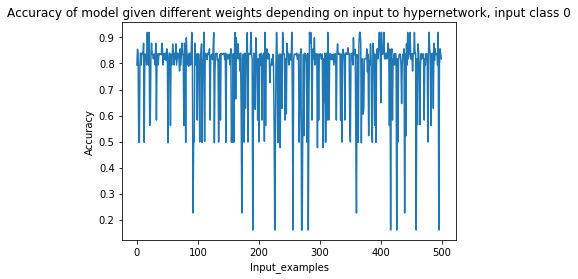

In [29]:
plt.plot(accu_class0)
plt.xlabel('Input_examples')
plt.ylabel('Accuracy')
plt.title('Accuracy of model given different weights depending on input to hypernetwork, input class 0')
plt.show()

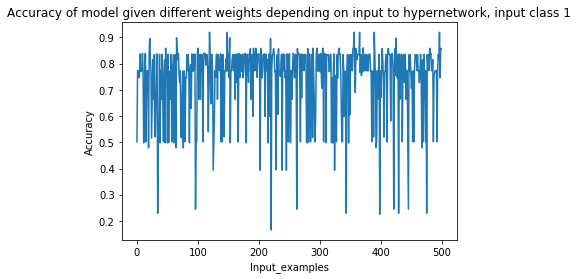

In [30]:
plt.plot(accu_class1)
plt.xlabel('Input_examples')
plt.ylabel('Accuracy')
plt.title('Accuracy of model given different weights depending on input to hypernetwork, input class 1')
plt.show()

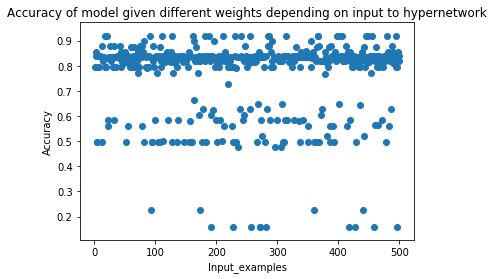

In [31]:
x_values = range(1, len(accu_class0) + 1)  # x-axis values (example indices)
#y_values = [3.2, 2.1, 4.5, 1.8, ...]  # y-axis values (corresponding values for each example)

# Plotting
plt.scatter(x_values, accu_class0)  # Scatter plot with dots
plt.xlabel('Input_examples')
plt.ylabel('Accuracy')
plt.title('Accuracy of model given different weights depending on input to hypernetwork')
plt.show()

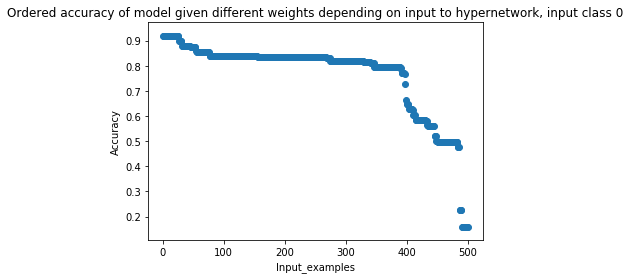

In [32]:
sorted_accu_class0 = np.sort(accu_class0)[::-1]
x_values = range(1, len(accu_class0) + 1)  # x-axis values (example indices)
#y_values = [3.2, 2.1, 4.5, 1.8, ...]  # y-axis values (corresponding values for each example)

# Plotting
plt.scatter(x_values, sorted_accu_class0)  # Scatter plot with dots
plt.xlabel('Input_examples')
plt.ylabel('Accuracy')
plt.title('Ordered accuracy of model given different weights depending on input to hypernetwork, input class 0')
plt.show()

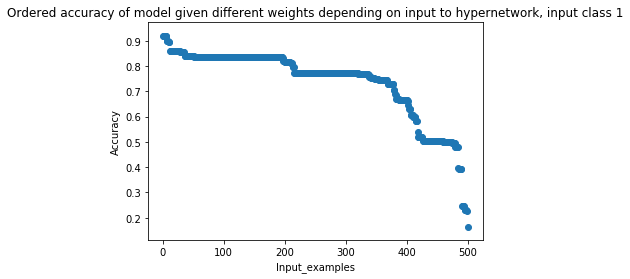

In [33]:
sorted_accu_class1 = np.sort(accu_class1)[::-1]
x_values = range(1, len(accu_class1) + 1)  # x-axis values (example indices)
#y_values = [3.2, 2.1, 4.5, 1.8, ...]  # y-axis values (corresponding values for each example)

# Plotting
plt.scatter(x_values, sorted_accu_class1)  # Scatter plot with dots
plt.xlabel('Input_examples')
plt.ylabel('Accuracy')
plt.title('Ordered accuracy of model given different weights depending on input to hypernetwork, input class 1')
plt.show()

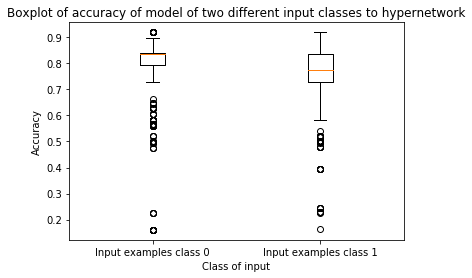

In [34]:
fig, ax = plt.subplots()

# Create the first boxplot
ax.boxplot(accu_class0, positions=[1], labels=['Input examples class 0'])

# Create the second boxplot
ax.boxplot(accu_class1, positions=[2], labels=['Input examples class 1'])

# Set labels and title for the plot
ax.set_xlabel('Class of input')
ax.set_ylabel('Accuracy')
ax.set_title('Boxplot of accuracy of model of two different input classes to hypernetwork')

# Display the plot
plt.show()

In [35]:
mean_class0 = np.mean(accu_class0)
print(mean_class0)
mode_class0 = st.mode(accu_class0)
print(mode_class0)
median_class0 = np.median(accu_class0)
print(median_class0)
std_class0 = np.std(accu_class0)
print(std_class0)


0.7674775016307831
ModeResult(mode=array([0.81770003]), count=array([48]))
0.8343499898910522
0.1522895809636492


In [36]:
mean_class1 = np.mean(accu_class1)
print(mean_class1)
mode_class1 = st.mode(accu_class1)
print(mode_class1)
median_class1 = np.median(accu_class1)
print(median_class1)
std_class1 = np.std(accu_class1)
print(std_class1)

0.7376653995215893
ModeResult(mode=array([0.83464998]), count=array([41]))
0.7730500102043152
0.1406623247795797


In [140]:
accu_class0[51]

0.4952999949455261

In [109]:
np.argmax(accu_class0)
x_train0[x_train0_samples[22]]

array([-0.19999999,  1.        ,  0.54509807, -0.5686275 ], dtype=float32)

In [141]:
plaatje = x_train0[x_train0_samples[51]]#[-0.11372548,  1.        ,  0.3176471 ,  0.6862745 ] #[-0.7882353,  1.       ,  0.6392157, -0.3098039]
plaatje = np.array(plaatje)
plaatje = (plaatje + 1) * 127.5
plaatje = plaatje.reshape(2, 2)


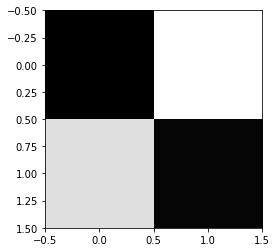

In [142]:
fig = plt.figure
plt.imshow(plaatje, cmap='gray')
plt.show()

In [7]:
from tensorflow import keras
from tensorflow.keras import layers


extractor = keras.Model(inputs=model.inputs,
                        outputs=[layer.output for layer in model.layers])
features = extractor(np.array([x_train[0]]))

# Naturally, this is not possible with models that are subclasses of Model that override call.
# Here's another example: instantiating a Model that returns the output of a specific named layer:
# model = ...  # create the original model

layer_name = 'test'
intermediate_layer_model = tf.keras.Model(inputs=model.input,
                                       outputs=model.get_layer(layer_name).output)
intermediate_output = intermediate_layer_model(np.array([x_train[1000]]))

intermediate_output

tf.Tensor([[-1.         -0.14117646  0.3215686  -1.        ]], shape=(1, 4), dtype=float32)
tf.Tensor(
[[ 1.  1. -1.  1. -1. -1.  1. -1. -1.  1.  1. -1.  1. -1.  1.  1.  1. -1.
   1. -1.  1. -1.  1. -1. -1.  1. -1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]], shape=(1, 36), dtype=float32)
tf.Tensor(
[[[ 1.  1. -1.  1. -1. -1.]
  [ 1. -1. -1.  1.  1. -1.]
  [ 1. -1.  1.  1.  1. -1.]
  [ 1. -1.  1. -1.  1. -1.]]], shape=(1, 4, 6), dtype=float32)
val:  tf.Tensor([[-1. -1.  1.  1.  1.  1.]], shape=(1, 6), dtype=float32)
tf.Tensor([[6. 2.]], shape=(1, 2), dtype=float32)


<tf.Tensor: shape=(1, 36), dtype=float32, numpy=
array([[ 1., -1.,  1.,  1., -1., -1.,  1., -1.,  1.,  1., -1.,  1.,  1.,
         1.,  1.,  1.,  1., -1.,  1.,  1.,  1., -1.,  1., -1.,  1., -1.,
        -1., -1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.]], dtype=float32)>

In [8]:
model_binary = tf.keras.models.Sequential()

model_binary.add(keras.Input(shape=(4)))

model_binary.add(lq.layers.QuantDense(6,
                                use_bias=False))

model_binary.add(lq.layers.QuantDense(2,
                                input_quantizer="ste_sign",
                                use_bias=False))

model_binary.add(tf.keras.layers.Activation("softmax"))

In [9]:
intermediate_output = intermediate_output[0]
layer1_2 = intermediate_output[:24]
layer2_3 = intermediate_output[24:]
layer1_2 = tf.reshape(layer1_2, [4,6])
layer2_3 = tf.reshape(layer2_3, [6,2])
print(layer1_2)
print(layer2_3)
weights = [layer1_2,layer2_3]
print(weights)
model_binary.built = True
model_binary.set_weights(weights)

tf.Tensor(
[[ 1. -1.  1.  1. -1. -1.]
 [ 1. -1.  1.  1. -1.  1.]
 [ 1.  1.  1.  1.  1. -1.]
 [ 1.  1.  1. -1.  1. -1.]], shape=(4, 6), dtype=float32)
tf.Tensor(
[[ 1. -1.]
 [-1. -1.]
 [ 1.  1.]
 [ 1.  1.]
 [ 1.  1.]
 [ 1.  1.]], shape=(6, 2), dtype=float32)
[<tf.Tensor: shape=(4, 6), dtype=float32, numpy=
array([[ 1., -1.,  1.,  1., -1., -1.],
       [ 1., -1.,  1.,  1., -1.,  1.],
       [ 1.,  1.,  1.,  1.,  1., -1.],
       [ 1.,  1.,  1., -1.,  1., -1.]], dtype=float32)>, <tf.Tensor: shape=(6, 2), dtype=float32, numpy=
array([[ 1., -1.],
       [-1., -1.],
       [ 1.,  1.],
       [ 1.,  1.],
       [ 1.,  1.],
       [ 1.,  1.]], dtype=float32)>]


In [90]:
fp_weights = model_binary.get_weights()  # get latent weights
print(fp_weights)

[array([[-1., -1.,  1.,  1.,  1., -1.],
       [ 1., -1., -1.,  1., -1., -1.],
       [ 1.,  1., -1.,  1.,  1.,  1.],
       [ 1., -1., -1., -1., -1.,  1.]], dtype=float32), array([[-1., -1.],
       [-1., -1.],
       [-1.,  1.],
       [-1., -1.],
       [ 1.,  1.],
       [-1., -1.]], dtype=float32)]


In [10]:
model_binary.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),loss="categorical_crossentropy",metrics=["accuracy"])

test_loss, test_acc = model_binary.evaluate(x_test, y_test)

67/67 [==============================] - 0s 1ms/step - loss: 1.0139 - accuracy: 0.5565


In [ ]:
a = np.array([[1, 2, 3],
              [4, 5, 6]])
b = tf.constant(a)

print(b[0])  # tf.Tensor([4 2 3], shape=(3,), dtype=int64)

In [57]:
x = np.array([[[1, 2],
            [2, 3],
            [4, 5],
            [6, 7]],
           [[1, 2],
            [2, 3],
            [3, 3],
            [4, 4]]])
y = np.array([[4, 5, 6, 7],
          [6, 7, 8, 9]])

print(x.shape)
print(y.shape)
#dot = np.tensordot(y,x, axes = ((1),(1)))
print(dot)
print(dot.shape)

#c = tf.linalg.matvec(y, x)

e = tf.einsum('bi,bik->bk', y, x)
print(e)

(2, 4, 2)
(2, 4)
[[[ 80 102]
  [ 60  69]]

 [[106 136]
  [ 80  93]]]
(2, 2, 2)
tf.Tensor(
[[ 80 102]
 [ 80  93]], shape=(2, 2), dtype=int32)
